# Python library : torch_mi

The torch_mi library provides implementations of three different methods for calculating Mutual Information:

- KNN (K-Nearest Neighbors)
- KDE (Kernel Density Estimation)
- Vectorized bins count method that can be differentiable.

These methods can be used to measure the amount of information shared between two variables in a dataset


# References :

- [KNN] "Estimating Mutual Information", Alexander Kraskov, Harald Stoegbauer, Peter Grassberger - https://arxiv.org/abs/cond-mat/0305641

- [Bins] https://en.wikipedia.org/wiki/Mutual_information

- [KDE] "Estimation of Mutual Information Using Kernel Density Estimators", Moon, Young-Il & Rajagopalan, Balaji & Lall, Upmanu - https://www.researchgate.net/publication/13324976_Estimation_of_Mutual_Information_Using_Kernel_Density_Estimators


# Install library


In [1]:
%%bash
if !python -c "import torch_mi" 2>/dev/null; then
    pip install https://github.com/Simon-Bertrand/MutualInformation-PyTorch/archive/main.zip
fi

# Import library


In [2]:
import torch_mi

# Generate some data and define some utils functions


In [3]:
%%bash
pip install matplotlib

In [4]:
import torch, math
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt


def createCovMat(stdX, stdY, p):
    return torch.tensor([[stdX**2, p * stdX * stdY], [p * stdX * stdY, stdY**2]])


def miGroundTruth(covMat):
    r = covMat[0, 1] / covMat.diag().prod().sqrt()
    return -1 / 2 * math.log(1 - r**2)


def entropyGroundTruth(covMat):
    r = covMat[0, 1] / torch.diag(covMat).prod().sqrt()
    return (
        1 / 2 + 1 / 2 * math.log(2 * math.pi) + math.log(covMat[0, 0].sqrt()),
        1 / 2 + 1 / 2 * math.log(2 * math.pi) + math.log(covMat[1, 1].sqrt()),
        1
        + math.log(2 * math.pi)
        + math.log(torch.diag(covMat).prod().sqrt())
        + 1 / 2 * math.log(1 - r**2),
    )


def getMultivariateNormal(covMat, meanX, meanY):
    return MultivariateNormal(torch.Tensor([meanX, meanY]), covMat)

In [5]:
# Define parameters
nNeighbours = 3
nBins = 20

# Define data parameters and generate it
r = 0.99
means = [1, 1]
covMat = createCovMat(1, 1, r)
B, C, H, W = 1, 1, 32, 32
x, y = getMultivariateNormal(covMat, *means).sample((B, C, H, W)).moveaxis(-1, 0)

# Print ground truth mutual information for the normal multivariate case
print("Ground truth MI:", miGroundTruth(covMat))

# Instanciate four methods
rangeOpts = dict(percentile=0.001, gain=0)
binsMiSoft = torch_mi.BinsCountMutualInformation(
    nBins=nBins, mode="soft", rangeOpts=rangeOpts
)  # Default mode
binsMiDiscrete = torch_mi.BinsCountMutualInformation(
    nBins=nBins, mode="discrete", rangeOpts=rangeOpts
)
kdeMi = torch_mi.KdeMutualInformation(nBins=nBins, rangeOpts=rangeOpts)
knnMi = torch_mi.KnnMutualInformation(nNeighbours=nNeighbours)

BC, HW = x.size(0) * x.size(1), x.size(2) * x.size(3)

Ground truth MI: 1.9585186697929657


# Plot density based joint distribution


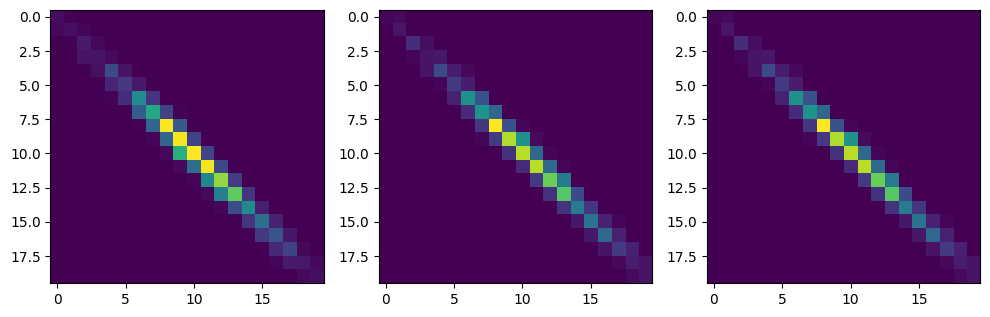

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].imshow(kdeMi.computePxy(x.view(BC, HW), y.view(BC, HW))[0])
axes[1].imshow(binsMiSoft.computePxy(x.view(BC, HW), y.view(BC, HW))[0])
axes[2].imshow(binsMiDiscrete.computePxy(x.view(BC, HW), y.view(BC, HW))[0])

# Compute Mutual Information for each method


In [7]:
dict(
    binsMiSoft=float(binsMiSoft(x, y)),
    binsMiDiscrete=float(binsMiDiscrete(x, y)),
    kdeMi=float(kdeMi(x, y)),
    knnMi=float(knnMi(x, y)),
    gt=float(miGroundTruth(covMat)),
)

{'binsMiSoft': 1.7509595155715942,
 'binsMiDiscrete': 1.7509595155715942,
 'kdeMi': 1.6319304704666138,
 'knnMi': 2.012399673461914,
 'gt': 1.9585186697929657}

# Compute some stats


In [8]:
%%bash
pip install tqdm pandas

In [9]:
import time
import pandas as pd
from tqdm import tqdm

nRealizations = 64


def task(args):
    r, n = args
    covMat = createCovMat(1, 1, r)
    means = [0, 0]
    x, y = getMultivariateNormal(covMat, *means).sample((nRealizations, 1, n, n)).moveaxis(-1, 0)
    start = time.time()
    knn = knnMi(x, y).mean()
    knnTime = 1000 * (time.time() - start) / nRealizations

    start = time.time()
    kde = kdeMi(x, y).mean()
    kdeTime = 1000 * (time.time() - start) / nRealizations

    start = time.time()
    bins = binsMiSoft(x, y).mean()
    binsTime = 1000 * (time.time() - start) / nRealizations

    return {
        "n": float(n**2),
        "r": float(r),
        "gt": float(miGroundTruth(covMat)),
        **dict(zip(["varX", "varY"], covMat.diag().tolist())),
        **dict(zip(["meanX", "meanY"], means)),
        "knn:score": float(knn),
        "kde:score": float(kde),
        "bins:score": float(bins),
        "knn:duration": float(knnTime),
        "kde:duration": float(kdeTime),
        "bins:duration": float(binsTime),
    }


rs = (1 - (-2 * torch.linspace(0, -0.5 * math.log(1 - 0.99**2), 25)).exp()).sqrt()
N = torch.logspace(1, 1.85, 7).to(torch.int)

stats = pd.DataFrame(
    list(
        tqdm(
            map(task, ((r, n) for r in rs for n in N)),
            total=len(rs) * len(N),
        )
    )
).assign(
    **{
        "knn:score_err": lambda x: (x["knn:score"] - x["gt"]) / (x["gt"].abs()),
        "kde:score_err": lambda x: (x["kde:score"] - x["gt"]) / (x["gt"].abs()),
        "bins:score_err": lambda x: (x["bins:score"] - x["gt"]) / (x["gt"].abs()),
    }
)
stats

100%|██████████| 175/175 [04:38<00:00,  1.59s/it]


,n,r,gt,varX,varY,meanX,meanY,knn:score,kde:score,bins:score,knn:duration,kde:duration,bins:duration,knn:score_err,kde:score_err,bins:score_err
0,100.0,0.00,-0.000000,1.0,1.0,0,0,0.026470,0.148049,1.014754,0.050105,3.156796,0.040006,inf,inf,inf
1,169.0,0.00,-0.000000,1.0,1.0,0,0,0.022425,0.141168,0.708642,0.156231,0.055358,0.057723,inf,inf,inf
2,361.0,0.00,-0.000000,1.0,1.0,0,0,0.021176,0.125674,0.390564,0.720613,0.091217,0.136267,inf,inf,inf
3,676.0,0.00,-0.000000,1.0,1.0,0,0,0.012514,0.114282,0.224953,2.707399,0.122227,0.232339,inf,inf,inf
4,1296.0,0.00,-0.000000,1.0,1.0,0,0,0.007499,0.099844,0.126344,9.110626,0.205077,0.407144,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,361.0,0.99,1.958519,1.0,1.0,0,0,1.969638,1.413813,1.725812,0.684023,0.090662,0.134714,0.005677,-0.278122,-0.118818
171,676.0,0.99,1.958519,1.0,1.0,0,0,1.984936,1.547285,1.703919,2.352342,0.116680,0.221536,0.013489,-0.209972,-0.129996
172,1296.0,0.99,1.958519,1.0,1.0,0,0,1.982244,1.662663,1.687847,8.944150,0.199590,0.426222,0.012114,-0.151061,-0.138202
173,2601.0,0.99,1.958519,1.0,1.0,0,0,1.973207,1.761444,1.677549,35.705552,0.423536,0.783280,0.007499,-0.100624,-0.143460


# Plot method precision


In [10]:
!pip install seaborn

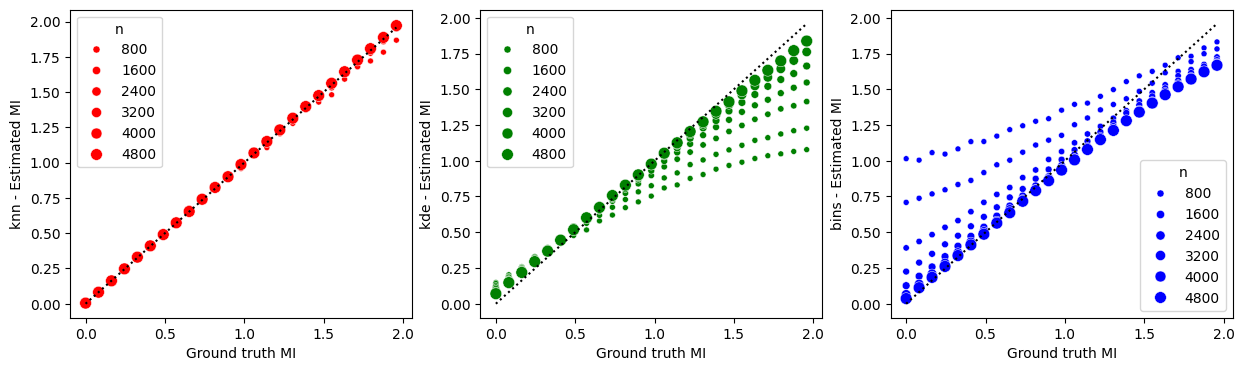

In [11]:
import seaborn as sns

fig, axis = plt.subplots(1, 3, figsize=(15, 4))
plotsMetadata = [
    dict(y="knn:score", color="r"),
    dict(y="kde:score", color="g"),
    dict(y="bins:score", color="b"),
]
for i, ax in enumerate(axis):
    sns.scatterplot(
        data=stats,
        size="n",
        x="gt",
        y=plotsMetadata[i]["y"],
        ax=ax,
        color=plotsMetadata[i]["color"],
    )
    ax.plot(
        *2 * [torch.linspace(stats["gt"].min(), stats["gt"].max(), 40)],
        linestyle="dotted",
        color="black",
    )
    ax.set_xlabel("Ground truth MI")
    ax.set_ylabel(plotsMetadata[i]["y"].split(":")[0] + " - Estimated MI")

# Plot method dependency with the correlation coefficient


<Axes: xlabel='r'>

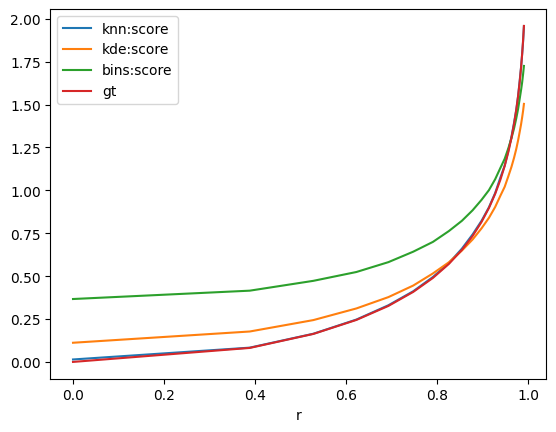

In [12]:
stats.groupby("r").agg(
    {
        "knn:score": "mean",
        "kde:score": "mean",
        "bins:score": "mean",
        "gt": "mean",
    }
).plot()

# Plot method dependency with the correlation coefficient


<Axes: xlabel='r', ylabel='Relative error'>

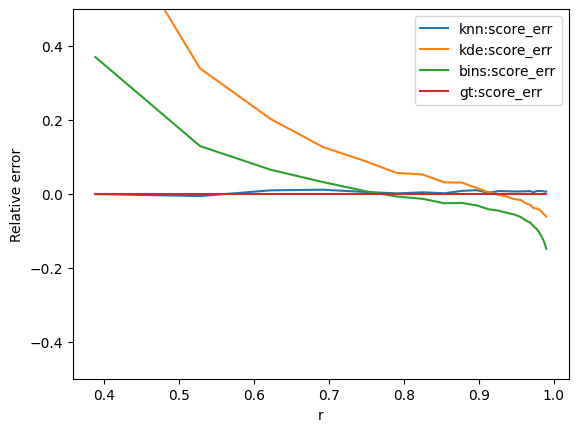

In [13]:
stats.where((stats["gt"] > 0) & (stats["n"] == stats["n"].max())).assign(
    **{"gt:score_err": lambda x: 0}
).groupby("r").agg(
    {
        "knn:score_err": "mean",
        "kde:score_err": "mean",
        "bins:score_err": "mean",
        "gt:score_err": "mean",
    }
).plot(
    ylim=[-0.50, 0.50], ylabel="Relative error"
)

# Show method durations


<Axes: xlabel='n', ylabel='Computation duration (s)'>

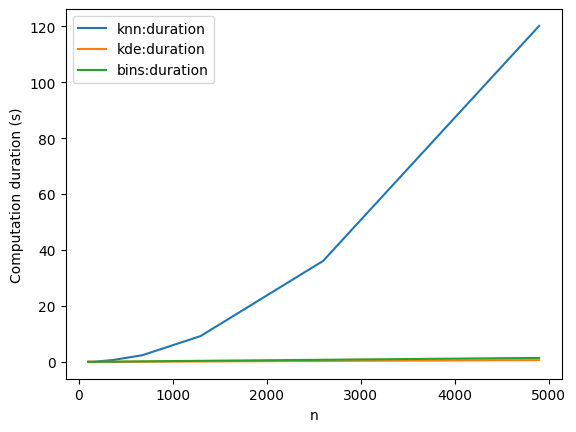

In [14]:
stats.groupby("n").agg(
    {
        "knn:duration": "mean",
        "kde:duration": "mean",
        "bins:duration": "mean",
    }
).plot(ylabel="Computation duration (s)")